# Libraries importing

In [301]:
import csv
import shap
import xgboost as xgb
from datetime import date
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from statistics import mean
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import linalg
from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

In [302]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score

# Data loading

In [303]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load the CSV file
file_path= '/content/drive/My Drive/shap_experiment/data'
df_processed_combined_data_daily = pd.read_csv(file_path+"/processed_combined_imputed_with_neighbors_df_processed_combined_data_daily.csv")

#df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)
df_processed_combined_data_daily.DateTime = pd.to_datetime(df_processed_combined_data_daily.DateTime)
df_PM10_daily = df_processed_combined_data_daily[['DateTime','Bjelave_PM10']]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Engineering

In [304]:
def add_all_time_features(df, datetime_col='DateTime', target_col='Bjelave_PM10'):
    df_dt=df.copy()
    df_dt['Day'] = df[datetime_col].dt.day.astype(np.float64)               # 1.0, 2.0, ..., 31.0
    df_dt['Month'] = df[datetime_col].dt.month.astype(np.float64)           # 1.0, 2.0, ..., 12.0
    df_dt['Year'] = df[datetime_col].dt.year.astype(np.float64)
    return df_dt

In [305]:
df_processed_combined_data_daily_dt = add_all_time_features(
    df=df_processed_combined_data_daily
)

In [306]:
df_processed_combined_data_daily_dt.shape

(1826, 15)

In [307]:
target_feature='Bjelave_PM10'

In [308]:
def add_lags(df):
    target_map = df[target_feature].to_dict()
    df['Bjelave_PM10_lag30'] = df[target_feature].shift(30)
    df['Bjelave_PM10_lag20'] = df[target_feature].shift(20)
    df['Bjelave_PM10_lag15'] = df[target_feature].shift(15)
    df['Bjelave_PM10_lag7'] = df[target_feature].shift(7)
    df['Bjelave_PM10_lag1'] = df[target_feature].shift(1)
    return df

In [309]:
df_processed_combined_data_daily_dt = add_lags(df_processed_combined_data_daily_dt)

In [310]:
print("df_processed_combined_data_daily.shape: ", df_processed_combined_data_daily.shape)
df_processed_combined_data_daily=df_processed_combined_data_daily.dropna()
print("df_processed_combined_data_daily.shape: ", df_processed_combined_data_daily.shape)

df_processed_combined_data_daily.shape:  (1826, 12)
df_processed_combined_data_daily.shape:  (1826, 12)


In [311]:
df_processed_combined_data_daily_dt.tail(2)

,DateTime,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2,Day,Month,Year,Bjelave_PM10_lag30,Bjelave_PM10_lag20,Bjelave_PM10_lag15,Bjelave_PM10_lag7,Bjelave_PM10_lag1
1824,2022-12-30,1.070833,159.541667,0.0,947.279167,6.429167,79.083333,19416.666667,4.000,67.841704,27.591008,54.974991,30.0,12.0,2022.0,67.309208,35.767727,103.846267,159.297166,50.187371
1825,2022-12-31,2.050000,128.875000,0.0,952.166667,6.670833,77.708333,18812.500000,2.775,48.536400,24.678667,32.047637,31.0,12.0,2022.0,44.765450,20.287982,14.177490,92.948049,67.841704


# Dataset Splitting

In [312]:
import matplotlib.pyplot as plt
def train_test_split(df, date):
    df = df.copy()
    train_data = df[df['DateTime'] < date].copy()
    test_data = df[df['DateTime'] >= date].copy() # df.DateTime = df.DateTime.dt.strftime('%d/%m/%Y %H:%M')
    return train_data, test_data

def train_test_split_from_to(df, start_date, end_date, slice_date):
    df = df.copy()
    train_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < slice_date)].copy()
    test_data = df[(df['DateTime'] >= slice_date) & (df['DateTime'] <= end_date)].copy()
    return train_data, test_data

def plot_train_test_data(train_data, test_data, date_column, label):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data')
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data')
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(label + ' Train and Test Data')
    plt.legend()
    plt.show()

In [313]:
def set_column_as_index(df, column_name='DateTime'):
  if column_name in df.columns:
    df.set_index(column_name, inplace=True)

In [314]:
def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(10,6))
    plt.boxplot(error)
    plt.show()

In [315]:
df_processed_combined_data_daily

,DateTime,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2
0,2018-01-01,1.876859,188.675592,0.012500,940.004167,3.316667,83.500000,17358.823529,7.117647,51.293265,20.956605,34.174856
1,2018-01-02,1.876859,188.675592,0.495833,936.579167,3.541667,93.041667,11216.666667,8.000000,51.293265,27.324796,37.907709
2,2018-01-03,1.876859,188.675592,0.187500,937.400000,3.237500,77.541667,12737.500000,7.112500,61.345475,19.669382,30.834321
3,2018-01-04,1.876859,188.675592,0.000000,935.770833,1.304167,91.500000,11312.500000,6.233333,41.241054,21.401833,31.298637
4,2018-01-05,1.876859,188.675592,0.000000,937.583333,5.183333,74.416667,18941.666667,5.520833,44.815521,20.001500,31.914025
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-12-27,2.029167,125.375000,0.479167,948.729167,7.879167,79.666667,18579.166667,6.358333,26.714598,22.752038,26.175499
1822,2022-12-28,1.450000,179.125000,0.000000,949.583333,4.591667,82.208333,19416.666667,4.937500,29.372987,23.098171,32.184576
1823,2022-12-29,2.187500,146.166667,0.000000,947.341667,5.354167,81.666667,18812.500000,4.187500,50.187371,25.431842,38.493039
1824,2022-12-30,1.070833,159.541667,0.000000,947.279167,6.429167,79.083333,19416.666667,4.000000,67.841704,27.591008,54.974991


In [316]:
#input window = 7
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=23)
#train_data_combined_ws_week, test_data_combined_ws_week = train_test_split(df_processed_combined_data_daily, date) #
#train_PM10_daily_ws_week, test_PM10_daily_ws_week = train_test_split(df_PM10_daily, date)

train_data_combined_ws_week_dt, test_data_combined_ws_week_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 15
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=15)
train_data_combined_ws_fifteen, test_data_combined_ws_fifteen = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_fifteen, test_PM10_daily_ws_fifteen = train_test_split(df_PM10_daily, date)

train_data_combined_ws_fifteen_dt, test_data_combined_ws_fifteen_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 30
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=30)
#train_data_combined_ws_thirty, test_data_combined_ws_thirty = train_test_split(df_processed_combined_data_daily, date) # #train_PM10_daily_ws_thirty, test_PM10_daily_ws_thirty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_thirty_dt, test_data_combined_ws_thirty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 60
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=60)
#train_data_combined_ws_sixty, test_data_combined_ws_sixty = train_test_split(df_processed_combined_data_daily, date) #train_PM10_daily_ws_sixty, test_PM10_daily_ws_sixty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_sixty_dt, test_data_combined_ws_sixty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 90
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=90)
#train_data_combined_ws_ninety, test_data_combined_ws_ninety = train_test_split(df_processed_combined_data_daily, date)
#train_PM10_daily_ws_ninety, test_PM10_daily_ws_ninety = train_test_split(df_PM10_daily, date)
train_data_combined_ws_ninety_dt, test_data_combined_ws_ninety_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

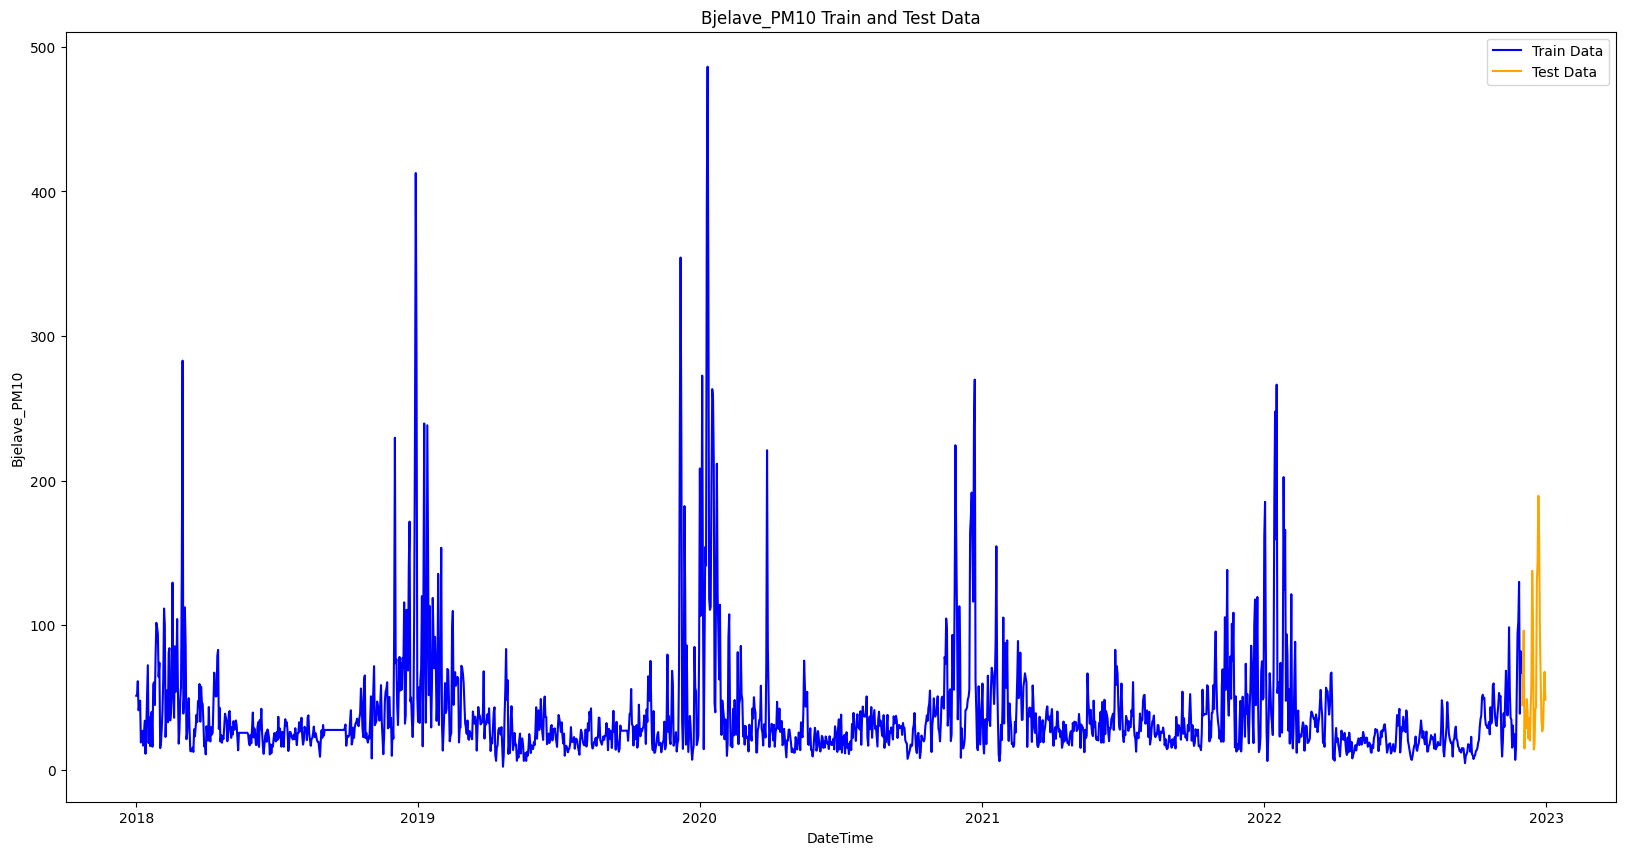

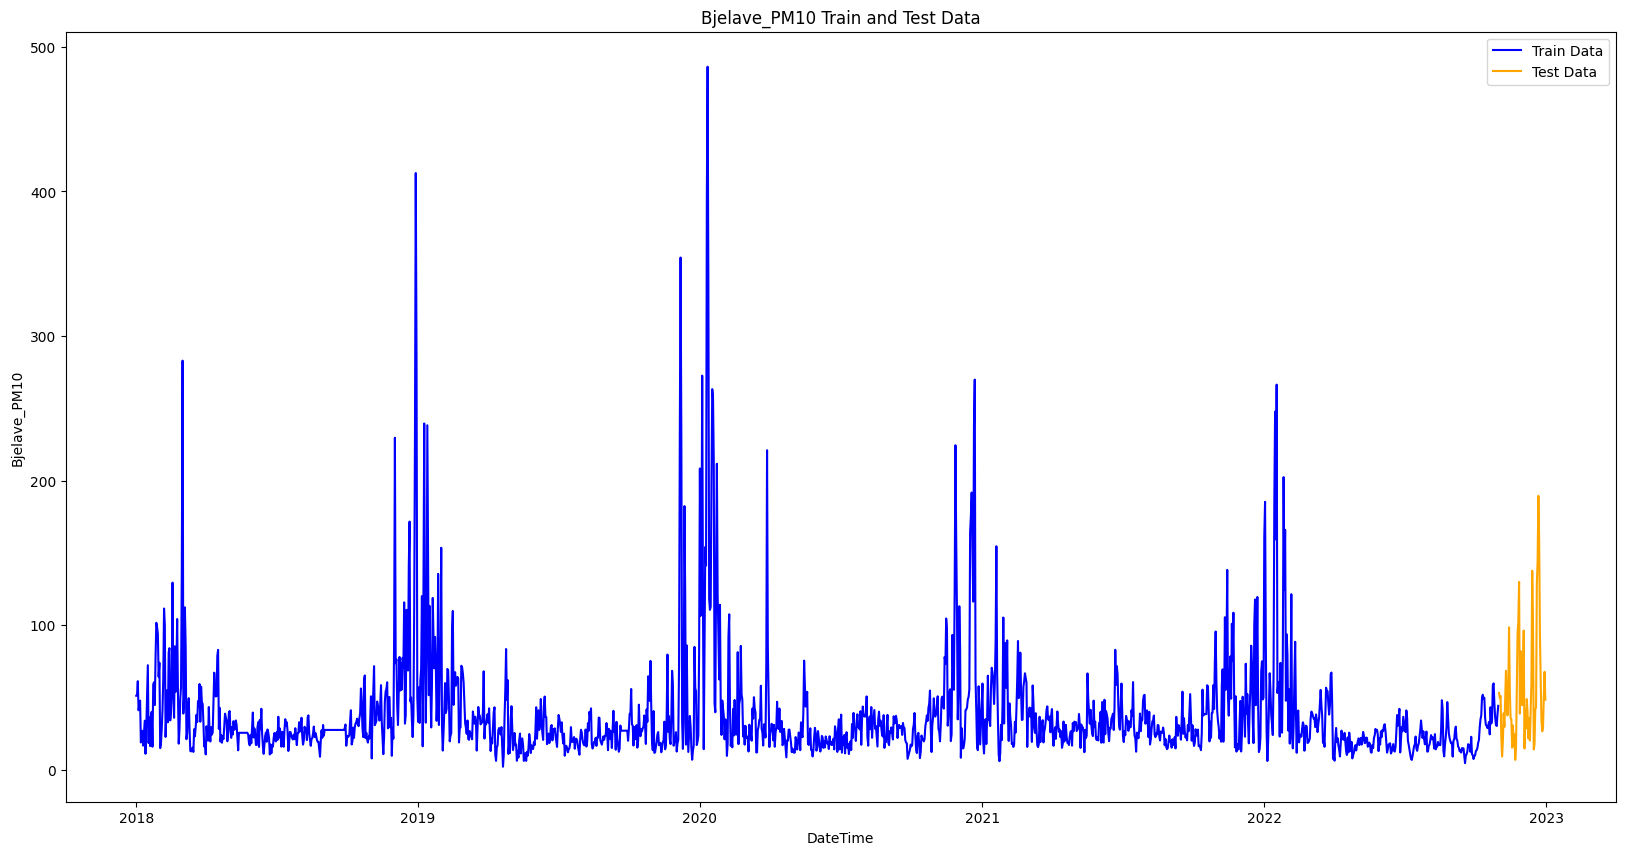

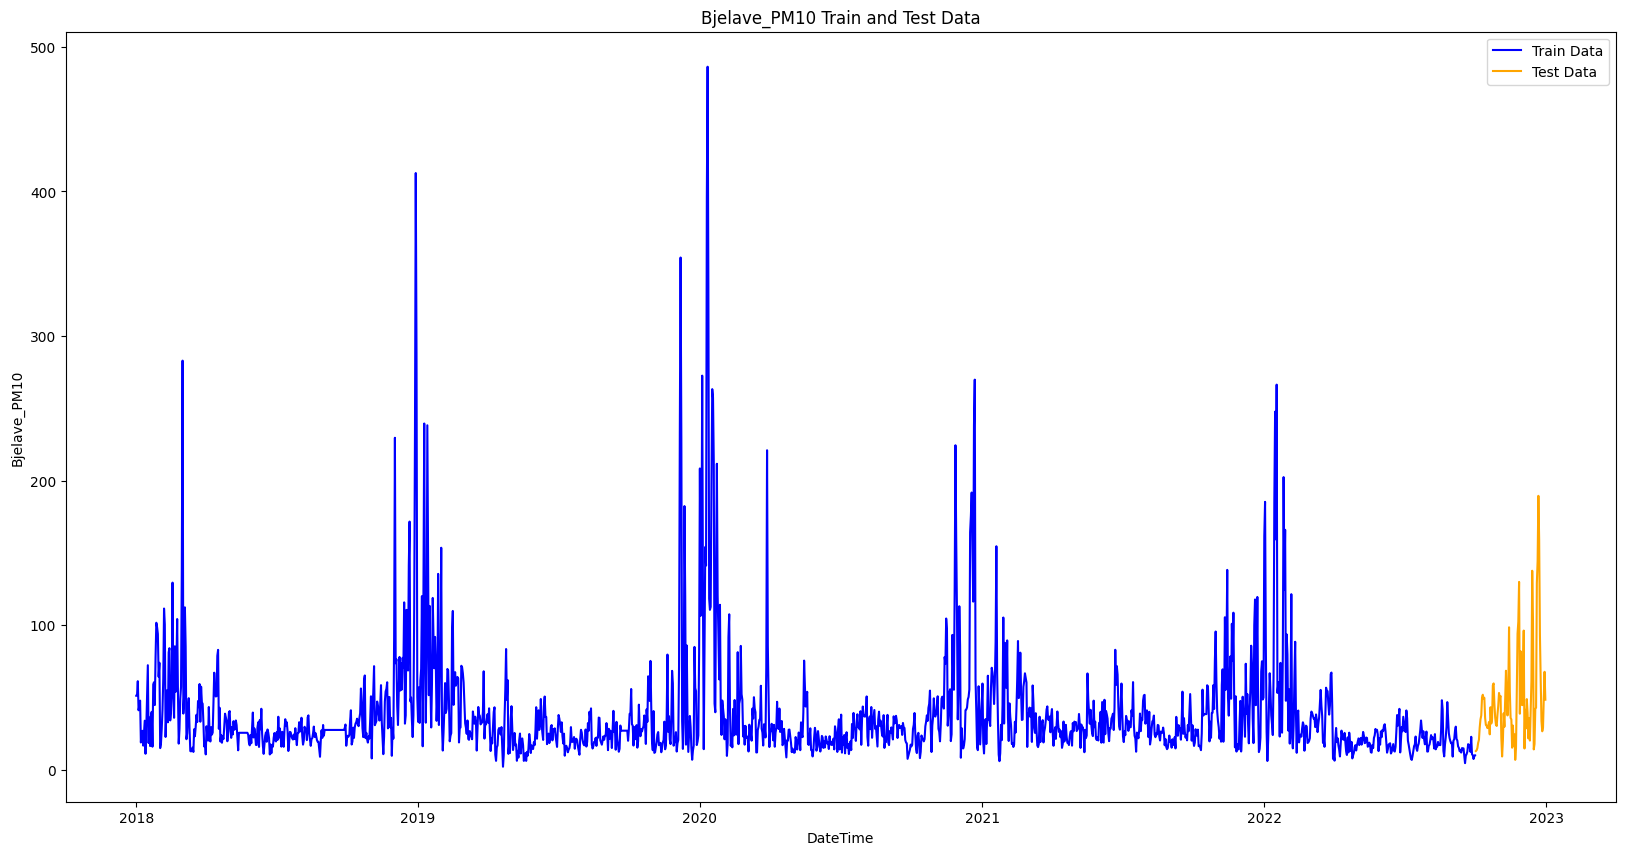

In [317]:
plot_train_test_data(train_data_combined_ws_thirty_dt, test_data_combined_ws_thirty_dt, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_data_combined_ws_sixty_dt, test_data_combined_ws_sixty_dt, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_data_combined_ws_ninety_dt, test_data_combined_ws_ninety_dt, 'DateTime', 'Bjelave_PM10')

In [318]:
for dataset in [train_data_combined_ws_thirty_dt, test_data_combined_ws_thirty_dt, train_data_combined_ws_sixty_dt, test_data_combined_ws_sixty_dt, train_data_combined_ws_ninety_dt, test_data_combined_ws_ninety_dt]:
  set_column_as_index(dataset)

# Time Series Forecasting with XGBoost

In [319]:
target_feature = 'Bjelave_PM10'
features=train_data_combined_ws_thirty_dt.columns.drop(target_feature).tolist()
features

['wind_speed',
 'wind_direction',
 'precipitation',
 'pressure',
 'temperature',
 'humidity',
 'visibility',
 'cloudiness',
 'Bjelave_SO2',
 'Bjelave_NO2',
 'Day',
 'Month',
 'Year',
 'Bjelave_PM10_lag30',
 'Bjelave_PM10_lag20',
 'Bjelave_PM10_lag15',
 'Bjelave_PM10_lag7',
 'Bjelave_PM10_lag1']

In [320]:
reg_ws_thirty_dt = xgb.XGBRegressor(n_estimators=1200, early_stopping_rounds=15, learning_rate=0.007, max_depth=9, min_child_weight=3, subsample=0.85, colsample_bytree=0.8)

reg_ws_thirty_dt.fit(train_data_combined_ws_thirty_dt[features], train_data_combined_ws_thirty_dt[target_feature],
    eval_set=[
        (train_data_combined_ws_thirty_dt[features], train_data_combined_ws_thirty_dt[target_feature]),
        (test_data_combined_ws_thirty_dt[features], test_data_combined_ws_thirty_dt[target_feature])
    ],verbose=1)

[0]	validation_0-rmse:38.51312	validation_1-rmse:51.41843
[1]	validation_0-rmse:38.30339	validation_1-rmse:50.98830
[2]	validation_0-rmse:38.11141	validation_1-rmse:50.60413
[3]	validation_0-rmse:37.90860	validation_1-rmse:50.15341
[4]	validation_0-rmse:37.71671	validation_1-rmse:49.83225
[5]	validation_0-rmse:37.51718	validation_1-rmse:49.42649
[6]	validation_0-rmse:37.32585	validation_1-rmse:49.09382
[7]	validation_0-rmse:37.13035	validation_1-rmse:48.72469
[8]	validation_0-rmse:36.95038	validation_1-rmse:48.45880
[9]	validation_0-rmse:36.78345	validation_1-rmse:48.25025
[10]	validation_0-rmse:36.58595	validation_1-rmse:47.76960
[11]	validation_0-rmse:36.40360	validation_1-rmse:47.31085
[12]	validation_0-rmse:36.22083	validation_1-rmse:47.00263
[13]	validation_0-rmse:36.03493	validation_1-rmse:46.58124
[14]	validation_0-rmse:35.85437	validation_1-rmse:46.35172
[15]	validation_0-rmse:35.68132	validation_1-rmse:45.83735
[16]	validation_0-rmse:35.51264	validation_1-rmse:45.53920
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=15,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.007, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1200,
             n_jobs=None, num_parallel_tree=None, ...)

In [321]:
reg_ws_sixty_dt = xgb.XGBRegressor(n_estimators=1200, early_stopping_rounds=15, learning_rate=0.007, max_depth=9, min_child_weight=3, subsample=0.85, colsample_bytree=0.8)

reg_ws_sixty_dt.fit(train_data_combined_ws_sixty_dt[features], train_data_combined_ws_sixty_dt[target_feature],
    eval_set=[
        (train_data_combined_ws_sixty_dt[features], train_data_combined_ws_sixty_dt[target_feature]),
        (test_data_combined_ws_sixty_dt[features], test_data_combined_ws_sixty_dt[target_feature])
    ],verbose=1)

[0]	validation_0-rmse:38.62811	validation_1-rmse:42.62537
[1]	validation_0-rmse:38.41756	validation_1-rmse:42.26383
[2]	validation_0-rmse:38.22145	validation_1-rmse:41.97562
[3]	validation_0-rmse:38.01529	validation_1-rmse:41.64889
[4]	validation_0-rmse:37.82247	validation_1-rmse:41.39223
[5]	validation_0-rmse:37.62603	validation_1-rmse:41.06275
[6]	validation_0-rmse:37.43608	validation_1-rmse:40.81793
[7]	validation_0-rmse:37.23930	validation_1-rmse:40.52924
[8]	validation_0-rmse:37.05910	validation_1-rmse:40.28853
[9]	validation_0-rmse:36.88788	validation_1-rmse:40.06134
[10]	validation_0-rmse:36.68718	validation_1-rmse:39.76098
[11]	validation_0-rmse:36.50994	validation_1-rmse:39.44278
[12]	validation_0-rmse:36.32527	validation_1-rmse:39.20114
[13]	validation_0-rmse:36.13893	validation_1-rmse:38.91580
[14]	validation_0-rmse:35.95723	validation_1-rmse:38.72684
[15]	validation_0-rmse:35.79206	validation_1-rmse:38.43678
[16]	validation_0-rmse:35.62593	validation_1-rmse:38.19078
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=15,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.007, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1200,
             n_jobs=None, num_parallel_tree=None, ...)

In [322]:
reg_ws_ninety_dt = xgb.XGBRegressor(n_estimators=1200, early_stopping_rounds=15, learning_rate=0.007, max_depth=9, min_child_weight=3, subsample=0.85, colsample_bytree=0.8)
reg_ws_ninety_dt.fit(train_data_combined_ws_ninety_dt[features], train_data_combined_ws_ninety_dt[target_feature], eval_set=[(train_data_combined_ws_ninety_dt[features], train_data_combined_ws_ninety_dt[target_feature]), (test_data_combined_ws_ninety_dt[features], test_data_combined_ws_ninety_dt[target_feature])], verbose=1)

[0]	validation_0-rmse:38.92755	validation_1-rmse:35.53557
[1]	validation_0-rmse:38.71617	validation_1-rmse:35.29659
[2]	validation_0-rmse:38.51744	validation_1-rmse:35.07837
[3]	validation_0-rmse:38.31091	validation_1-rmse:34.83914
[4]	validation_0-rmse:38.11518	validation_1-rmse:34.64587
[5]	validation_0-rmse:37.91367	validation_1-rmse:34.38207
[6]	validation_0-rmse:37.72200	validation_1-rmse:34.18403
[7]	validation_0-rmse:37.52371	validation_1-rmse:33.94971
[8]	validation_0-rmse:37.34045	validation_1-rmse:33.78011
[9]	validation_0-rmse:37.16855	validation_1-rmse:33.58925
[10]	validation_0-rmse:36.96785	validation_1-rmse:33.31744
[11]	validation_0-rmse:36.79070	validation_1-rmse:33.05789
[12]	validation_0-rmse:36.60226	validation_1-rmse:32.86399
[13]	validation_0-rmse:36.41393	validation_1-rmse:32.62179
[14]	validation_0-rmse:36.22983	validation_1-rmse:32.45989
[15]	validation_0-rmse:36.05413	validation_1-rmse:32.19436
[16]	validation_0-rmse:35.88599	validation_1-rmse:32.00244
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=15,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.007, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1200,
             n_jobs=None, num_parallel_tree=None, ...)

# Feature Importance

In [323]:
train_data_combined_ws_thirty_dt.columns

Index(['wind_speed', 'wind_direction', 'precipitation', 'pressure',
       'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10',
       'Bjelave_SO2', 'Bjelave_NO2', 'Day', 'Month', 'Year',
       'Bjelave_PM10_lag30', 'Bjelave_PM10_lag20', 'Bjelave_PM10_lag15',
       'Bjelave_PM10_lag7', 'Bjelave_PM10_lag1'],
      dtype='object')

In [324]:
reg_ws_sixty_dt.feature_names_in_

array(['wind_speed', 'wind_direction', 'precipitation', 'pressure',
       'temperature', 'humidity', 'visibility', 'cloudiness',
       'Bjelave_SO2', 'Bjelave_NO2', 'Day', 'Month', 'Year',
       'Bjelave_PM10_lag30', 'Bjelave_PM10_lag20', 'Bjelave_PM10_lag15',
       'Bjelave_PM10_lag7', 'Bjelave_PM10_lag1'], dtype='<U18')

In [325]:
fi_ws_sixty_dt =(pd.DataFrame(data=reg_ws_sixty_dt.feature_importances_, index=reg_ws_sixty_dt.feature_names_in_, columns=['importance'])).sort_values('importance')
fi_ws_thirty_dt =(pd.DataFrame(data=reg_ws_thirty_dt.feature_importances_, index=reg_ws_thirty_dt.feature_names_in_, columns=['importance'])).sort_values('importance')
fi_ws_ninety_dt =(pd.DataFrame(data=reg_ws_ninety_dt.feature_importances_, index=reg_ws_ninety_dt.feature_names_in_, columns=['importance'])).sort_values('importance')

<Axes: title={'center': 'Feature Importance'}>

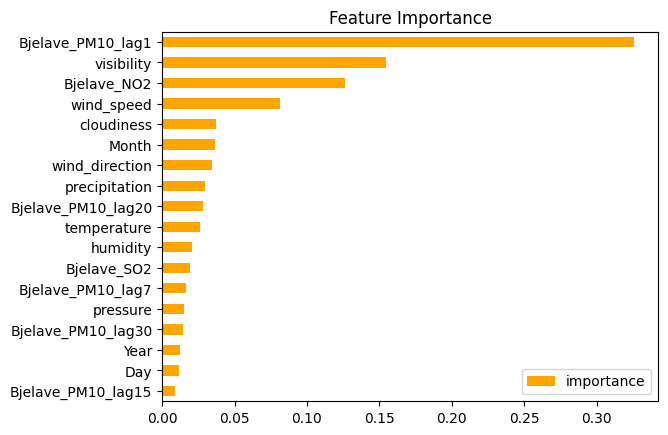

In [326]:
fi_ws_sixty_dt.plot(kind='barh', title='Feature Importance', color='orange')


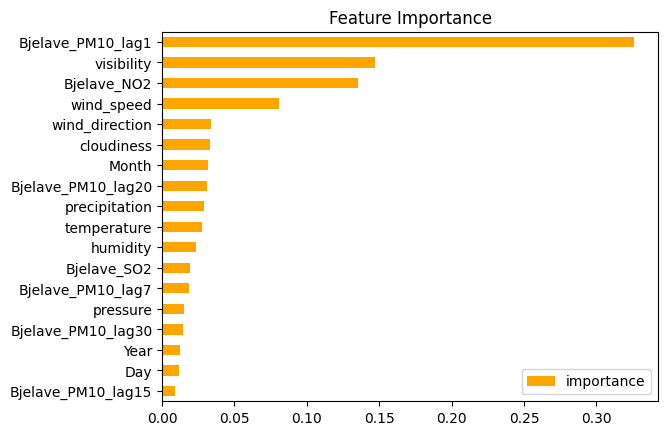

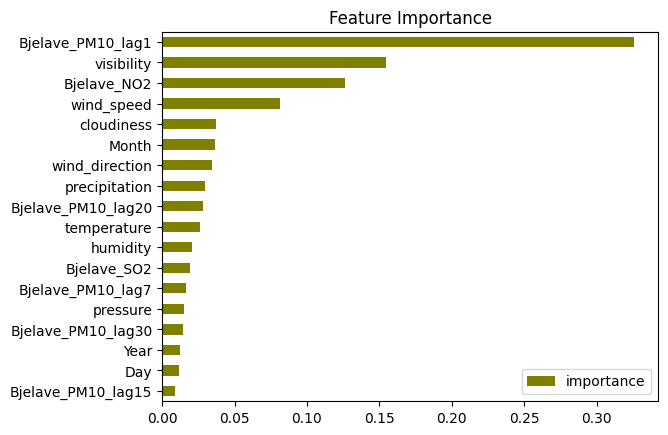

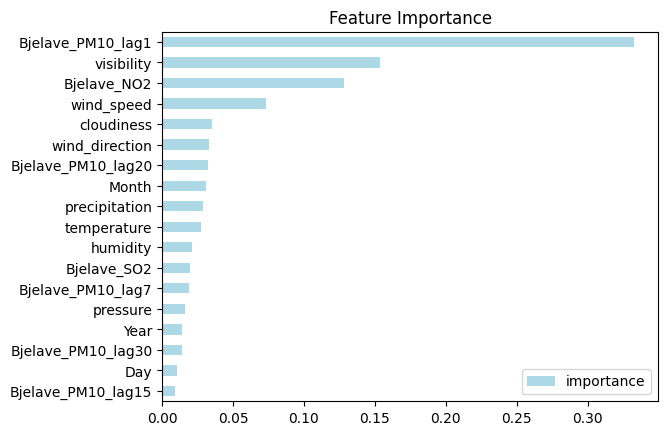

In [327]:
colors = ['orange', 'olive', 'lightblue']
for i, fi in enumerate([fi_ws_thirty_dt, fi_ws_sixty_dt, fi_ws_ninety_dt]):
   fi.plot(kind='barh', title='Feature Importance', color=colors[i])


# Predicting the Future

In [328]:
prediction_ws_thirty_dt = reg_ws_thirty_dt.predict(test_data_combined_ws_thirty_dt[features])
prediction_ws_sixty_dt = reg_ws_sixty_dt.predict(test_data_combined_ws_sixty_dt[features])
prediction_ws_ninety_dt = reg_ws_ninety_dt.predict(test_data_combined_ws_ninety_dt[features])

In [329]:
def evaluate_forecasts(actual_data, predicted_data):
  rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))
  mae = mean_absolute_error(actual_data, predicted_data)
  r2 = r2_score(actual_data, predicted_data)
  print("RMSE:", rmse)
  print("MAE:", mae)
  print("R2 Score:", r2)
  return rmse, mae, r2

In [330]:
prediction_ws_thirty_dt = reg_ws_thirty_dt.predict(test_data_combined_ws_thirty_dt[features])
prediction_ws_thirty_dt = pd.DataFrame({
   'Bjelave_PM10': prediction_ws_thirty_dt
}, index=test_data_combined_ws_thirty_dt.index)

prediction_ws_sixty_dt = reg_ws_sixty_dt.predict(test_data_combined_ws_sixty_dt[features])
prediction_ws_sixty_dt = pd.DataFrame({
   'Bjelave_PM10': prediction_ws_sixty_dt
}, index=test_data_combined_ws_sixty_dt.index)

prediction_ws_ninety_dt = reg_ws_ninety_dt.predict(test_data_combined_ws_ninety_dt[features])
prediction_ws_ninety_dt = pd.DataFrame({
   'Bjelave_PM10': prediction_ws_ninety_dt
}, index=test_data_combined_ws_ninety_dt.index)

In [331]:
(rmse_ws_thirty_dt, mae_ws_thirty_dt, r2_ws_thirty_dt) = evaluate_forecasts(test_data_combined_ws_thirty_dt['Bjelave_PM10'], prediction_ws_thirty_dt['Bjelave_PM10'])

RMSE: 18.846919940386304
MAE: 13.303471644698542
R2 Score: 0.8288883162529096


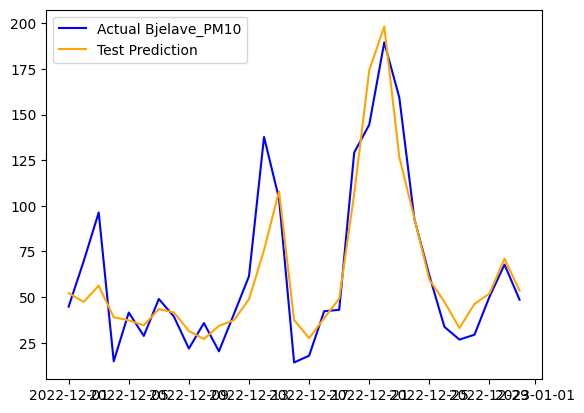

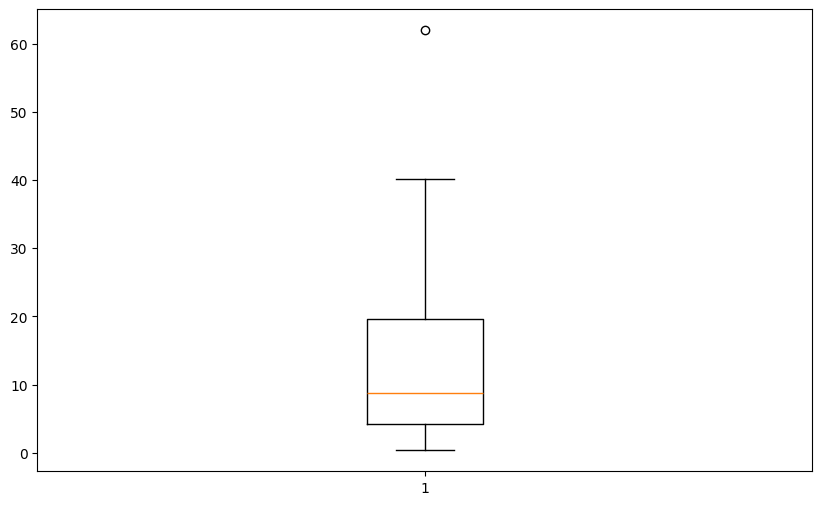

In [332]:
plt.plot(test_data_combined_ws_thirty_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_thirty_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_ws_thirty_dt['Bjelave_PM10'], test_data_combined_ws_thirty_dt['Bjelave_PM10'])

RMSE: 17.69393089982897
MAE: 13.575209409773816
R2 Score: 0.796704765696643


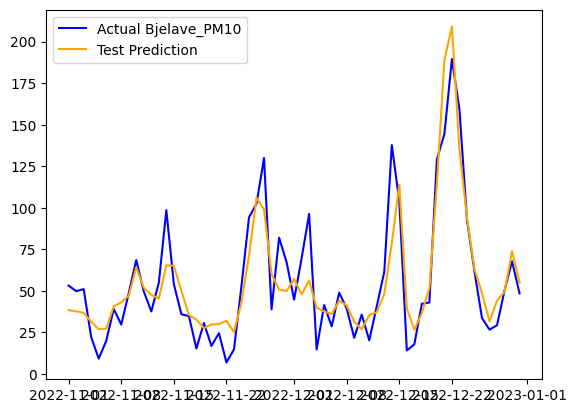

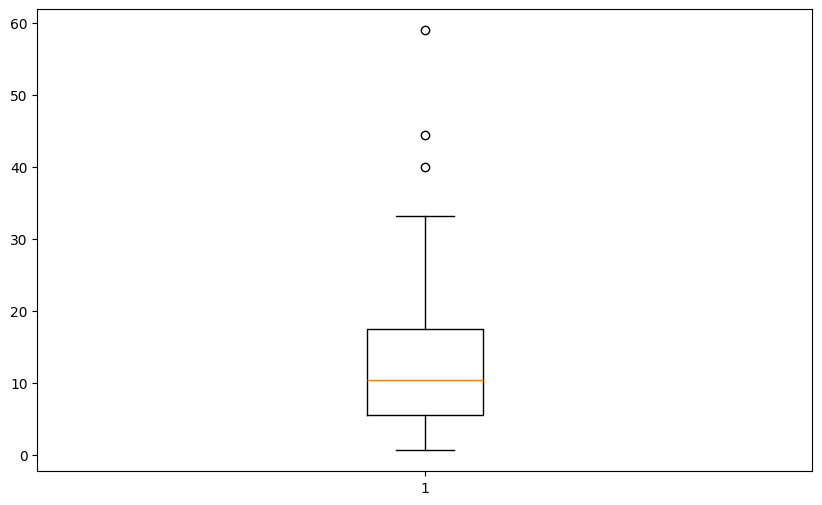

In [333]:
(rmse_ws_sixty_dt, mae_ws_sixty_dt, r2_ws_sixty_dt) = evaluate_forecasts(test_data_combined_ws_sixty_dt['Bjelave_PM10'], prediction_ws_sixty_dt['Bjelave_PM10'])
plt.plot(test_data_combined_ws_sixty_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_sixty_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()
plot_boxplot(prediction_ws_sixty_dt['Bjelave_PM10'], test_data_combined_ws_sixty_dt['Bjelave_PM10'])

RMSE: 15.741018797197098
MAE: 11.722643661164419
R2 Score: 0.7889439645096606


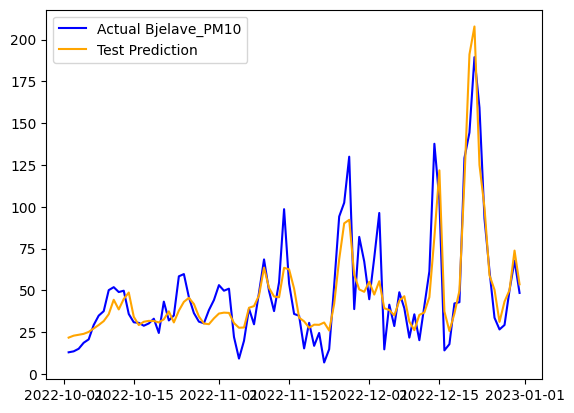

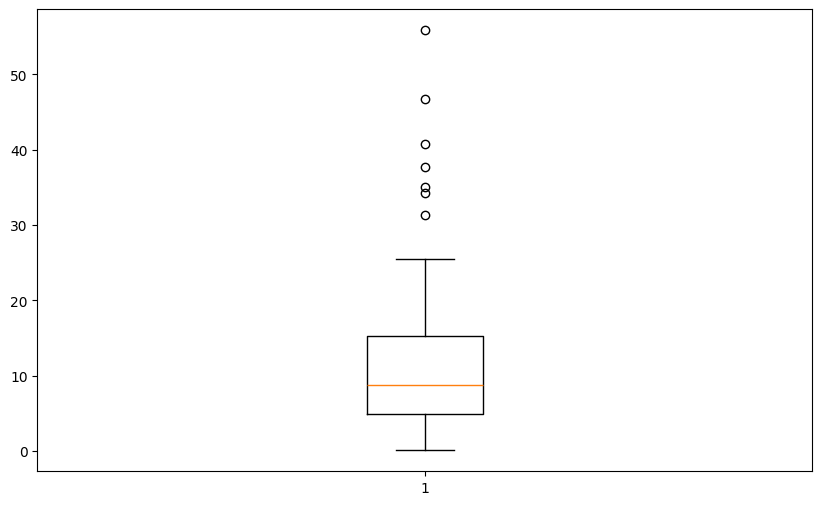

In [334]:
(rmse_ws_ninety_dt, mae_ws_ninety_dt, r2_ws_ninety_dt) = evaluate_forecasts(test_data_combined_ws_ninety_dt['Bjelave_PM10'], prediction_ws_ninety_dt['Bjelave_PM10'])
plt.plot(test_data_combined_ws_ninety_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_ninety_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()
plot_boxplot(prediction_ws_ninety_dt['Bjelave_PM10'], test_data_combined_ws_ninety_dt['Bjelave_PM10'])

# SHAP Analaysis

In [335]:
explainer_thirty = shap.TreeExplainer(reg_ws_thirty_dt)
explainer_sixty = shap.TreeExplainer(reg_ws_sixty_dt)
explainer_ninety = shap.TreeExplainer(reg_ws_ninety_dt)

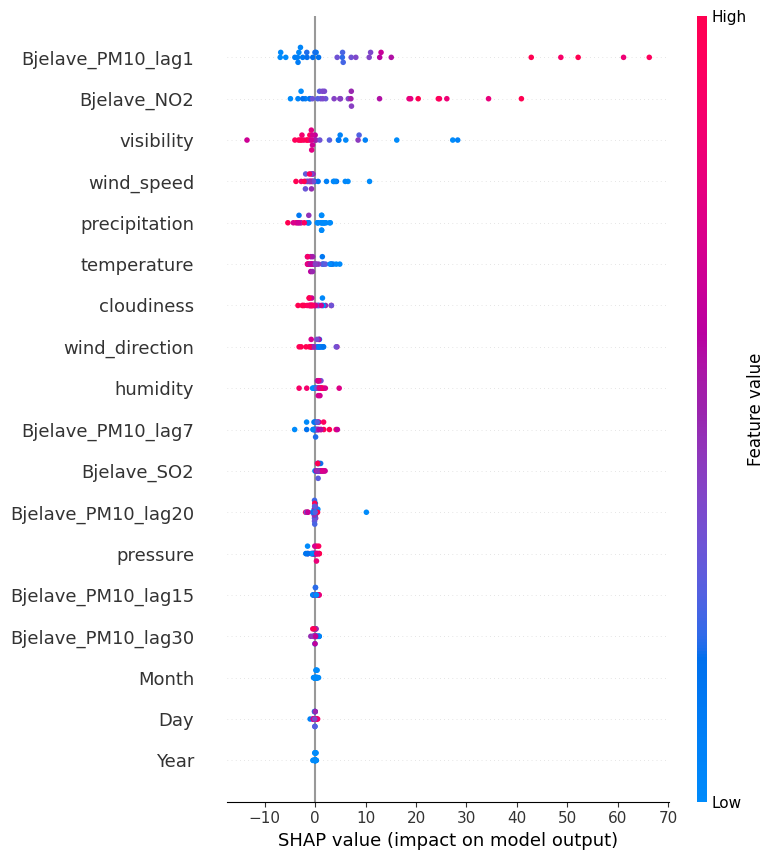

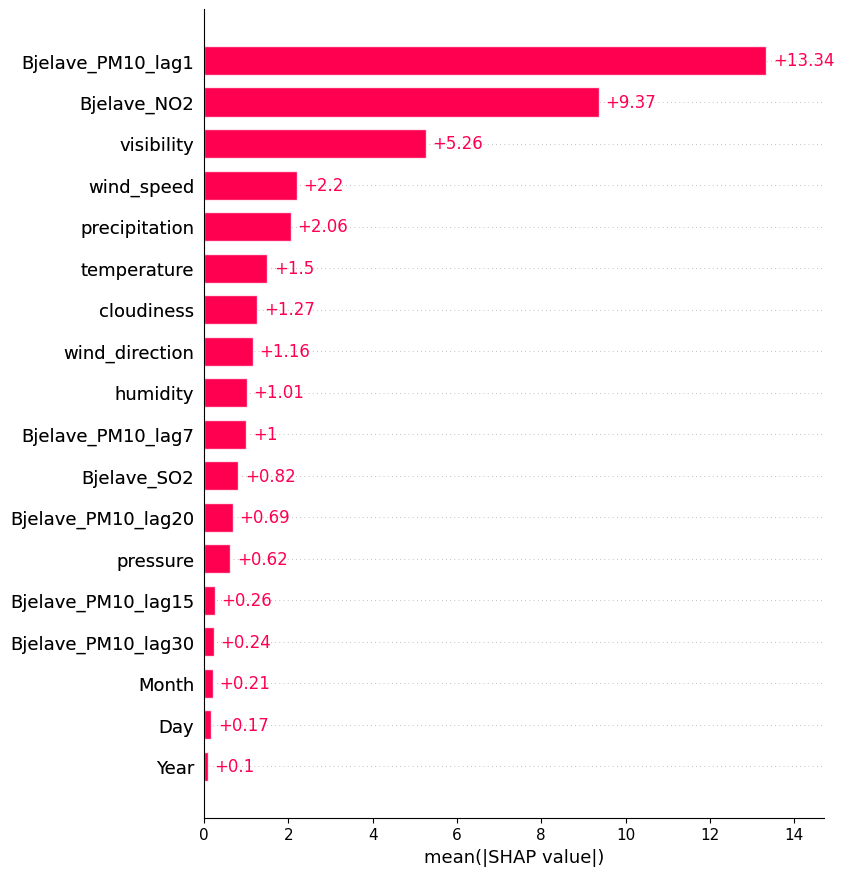

In [336]:
X_sample_thirty = test_data_combined_ws_thirty_dt[features]
shap_values_thirty = explainer_thirty.shap_values(X_sample_thirty)

shap.summary_plot(shap_values_thirty, X_sample_thirty)
explainer_thirty_mod = shap.Explanation(
    values=shap_values_thirty,
    base_values=np.array([explainer_thirty.expected_value] * len(shap_values_thirty)),
    data=X_sample_thirty.values,
    feature_names=features
)

shap.plots.bar(explainer_thirty_mod, max_display=len(features))

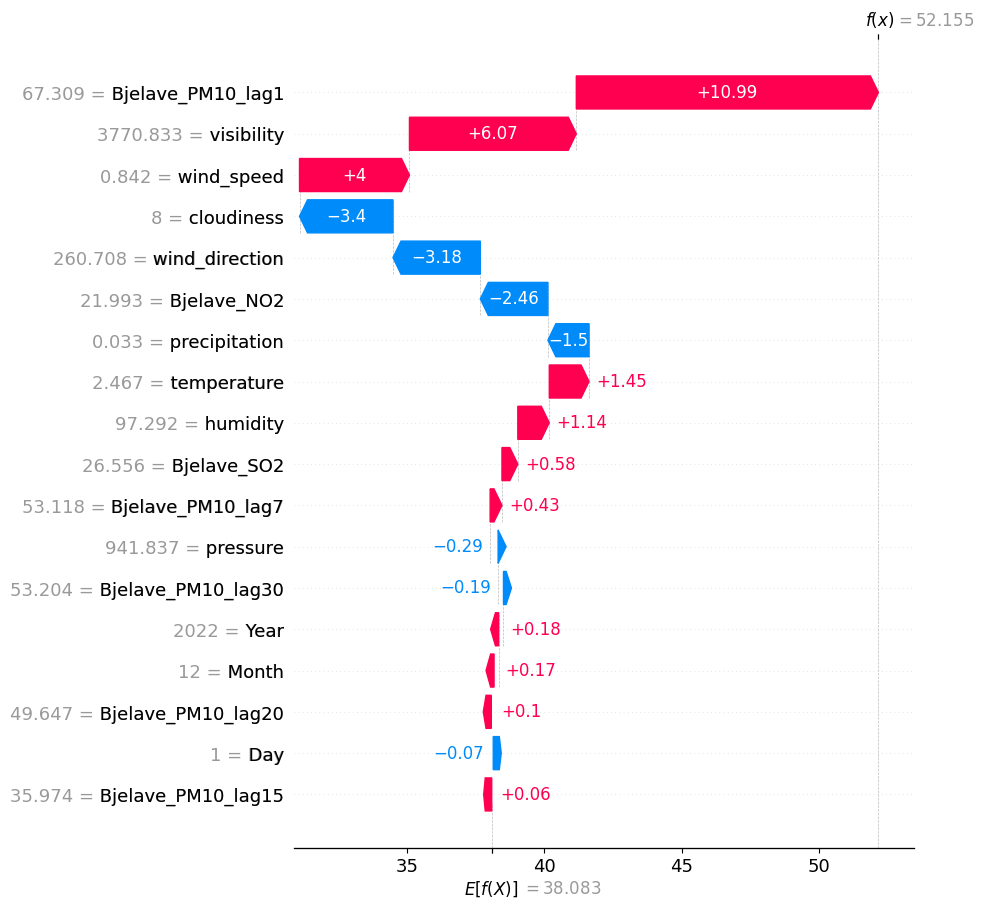

In [344]:
shap.plots.waterfall(explainer_thirty_mod[0], max_display=len(features))

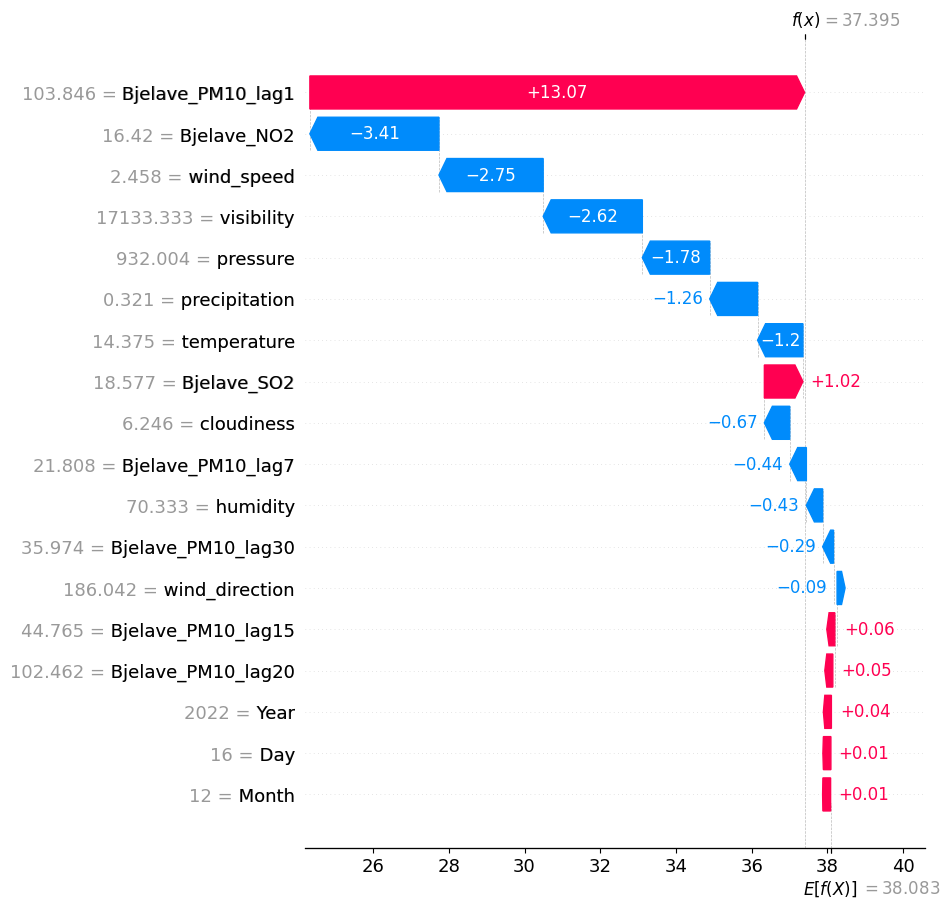

In [347]:
shap.plots.waterfall(explainer_thirty_mod[15], max_display=len(features))

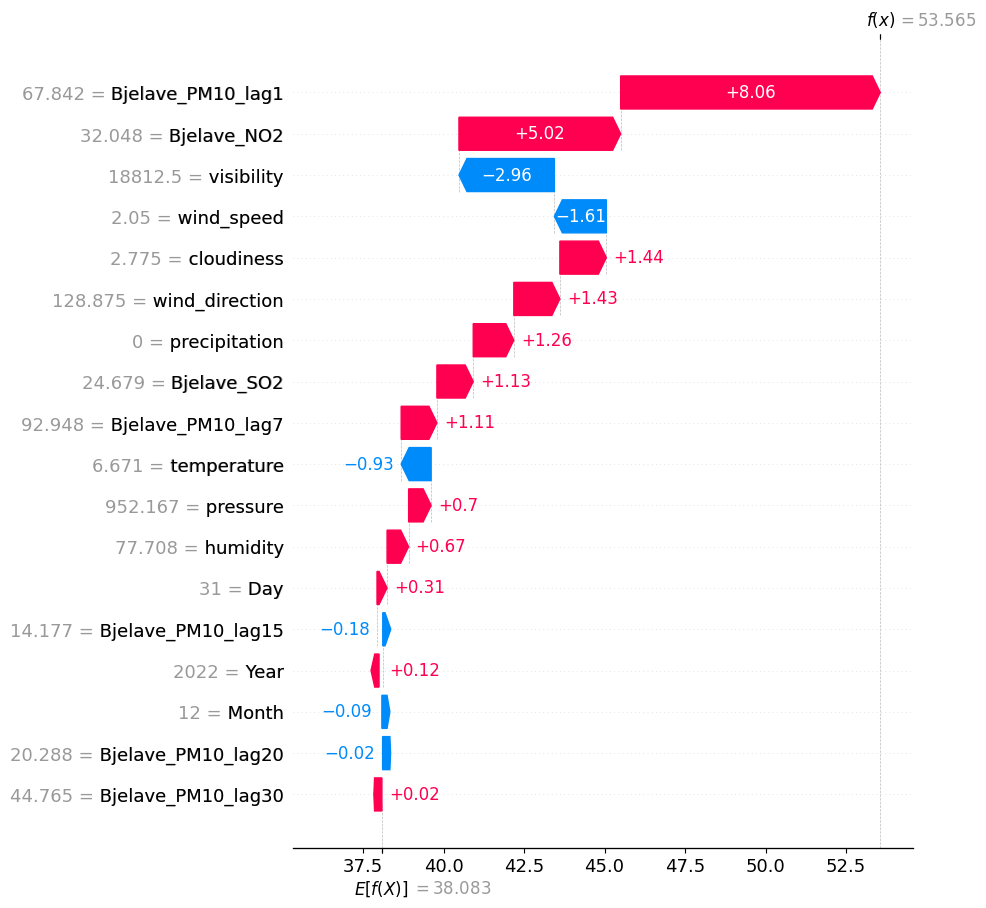

In [351]:
shap.plots.waterfall(explainer_thirty_mod[30], max_display=len(features))

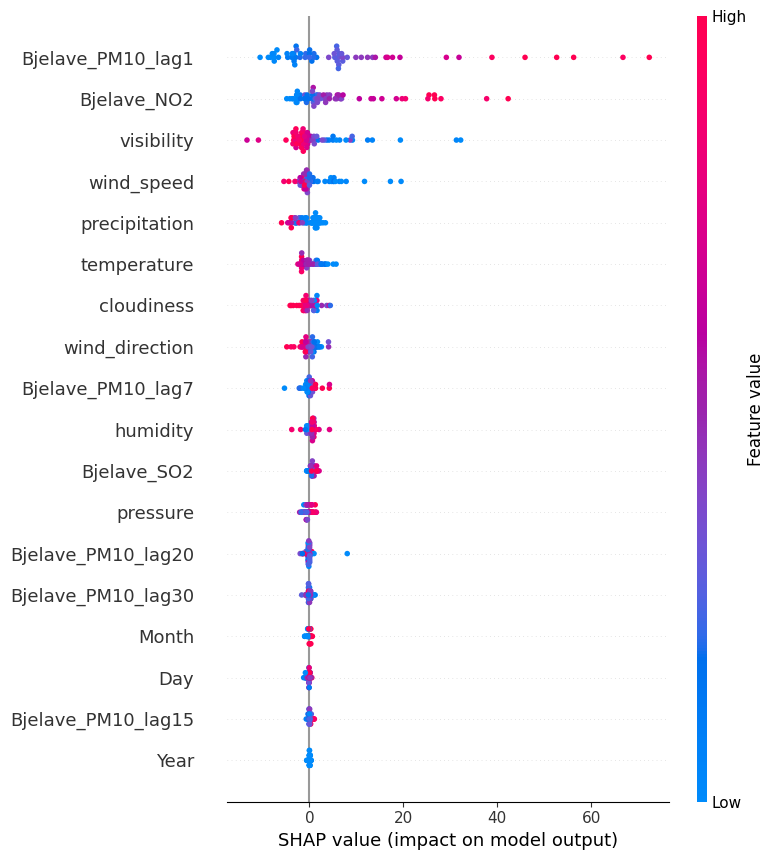

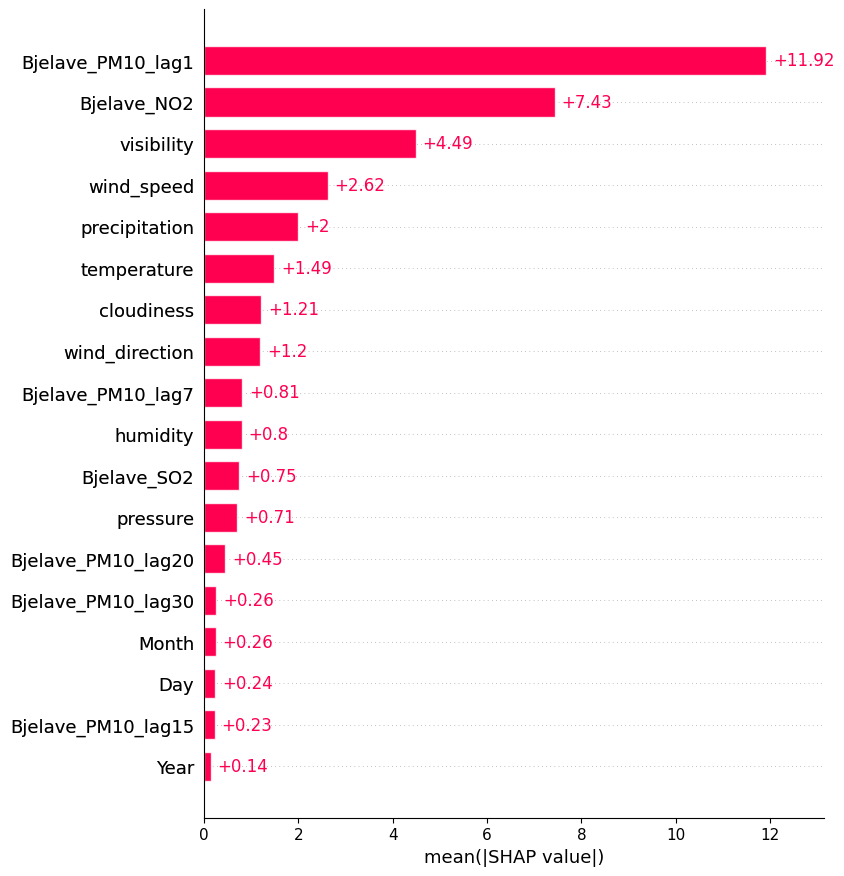

In [337]:
X_sample_ws_sixty = test_data_combined_ws_sixty_dt[features]
shap_values_sixty = explainer_sixty.shap_values(X_sample_ws_sixty)

shap.summary_plot(shap_values_sixty, X_sample_ws_sixty)
explainer_sixty_mod = shap.Explanation(
    values=shap_values_sixty,
    base_values=np.array([explainer_sixty.expected_value] * len(shap_values_sixty)),
    data=X_sample_ws_sixty.values,
    feature_names=features
)

shap.plots.bar(explainer_sixty_mod, max_display=len(features))

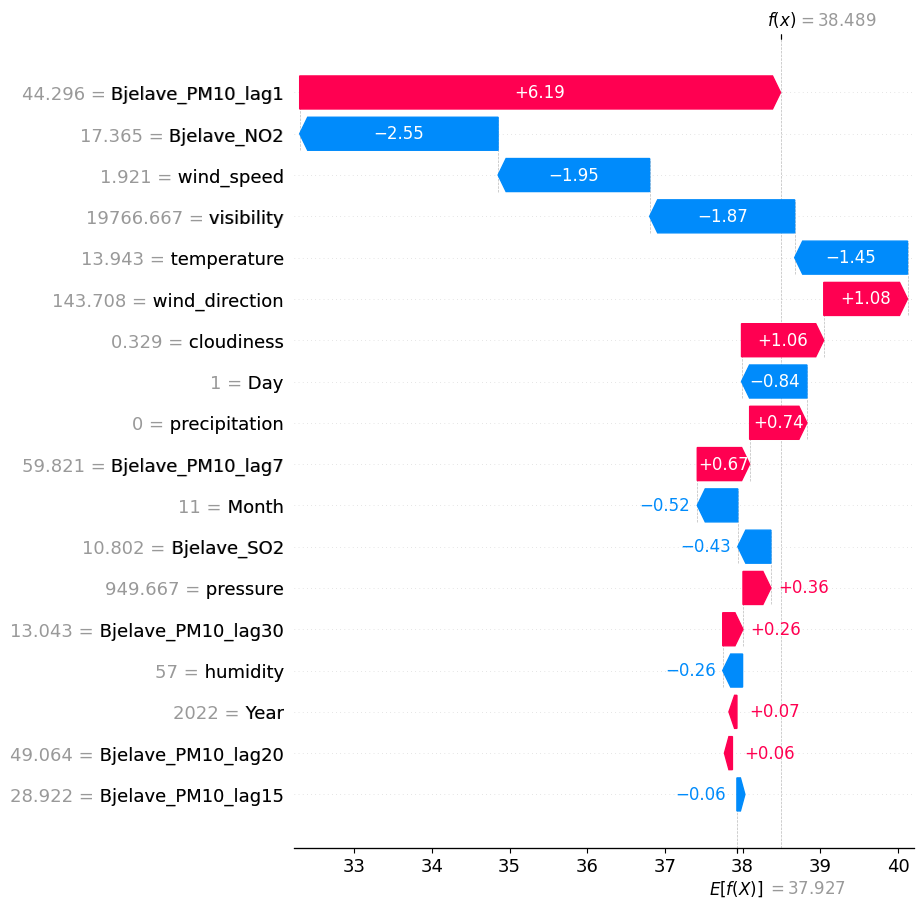

In [343]:
shap.plots.waterfall(explainer_sixty_mod[0], max_display=len(features))

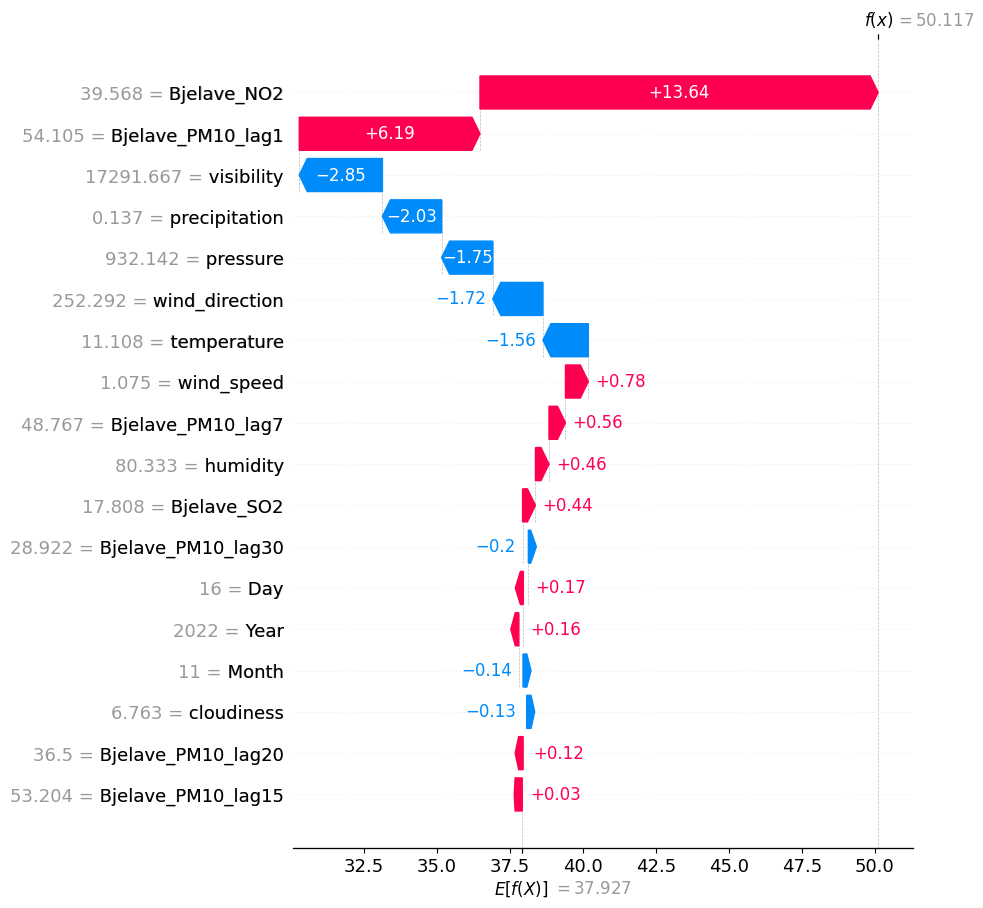

In [346]:
shap.plots.waterfall(explainer_sixty_mod[15], max_display=len(features))

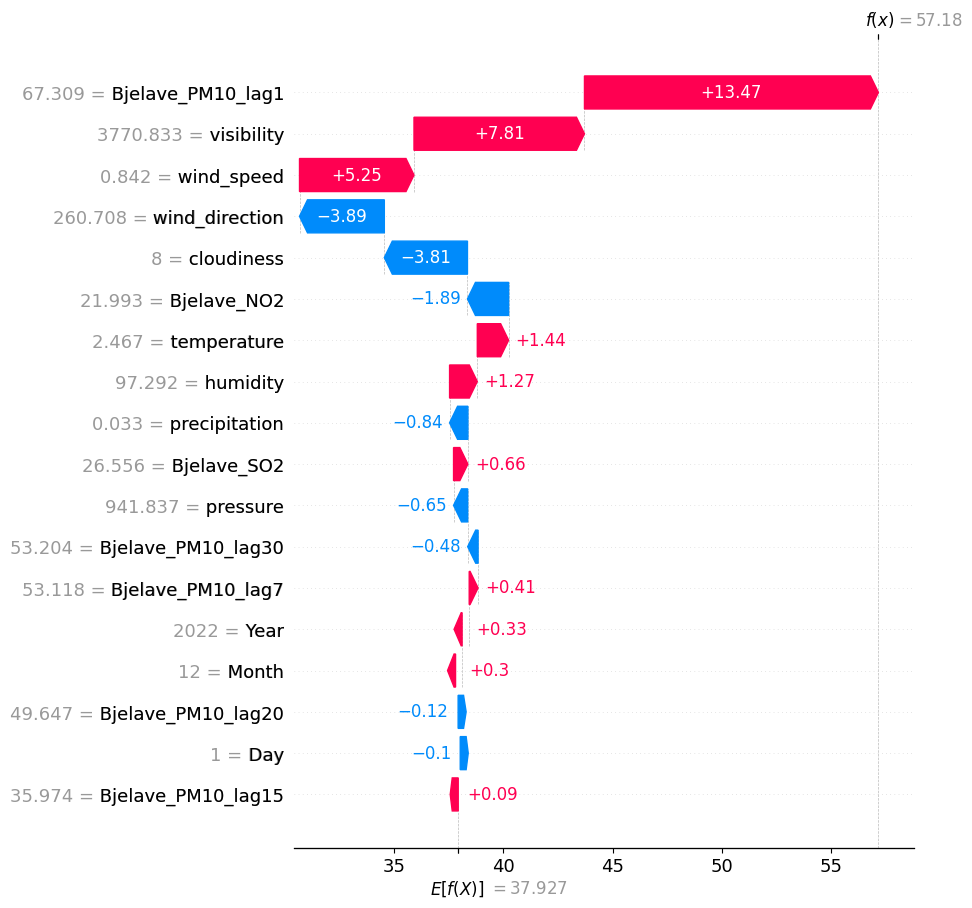

In [350]:
shap.plots.waterfall(explainer_sixty_mod[30], max_display=len(features))

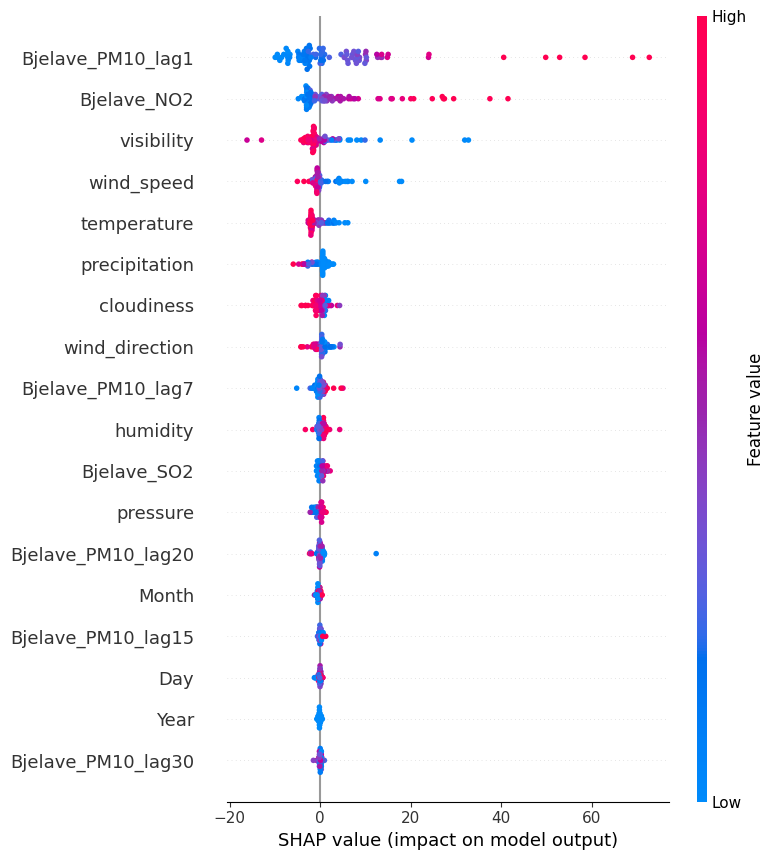

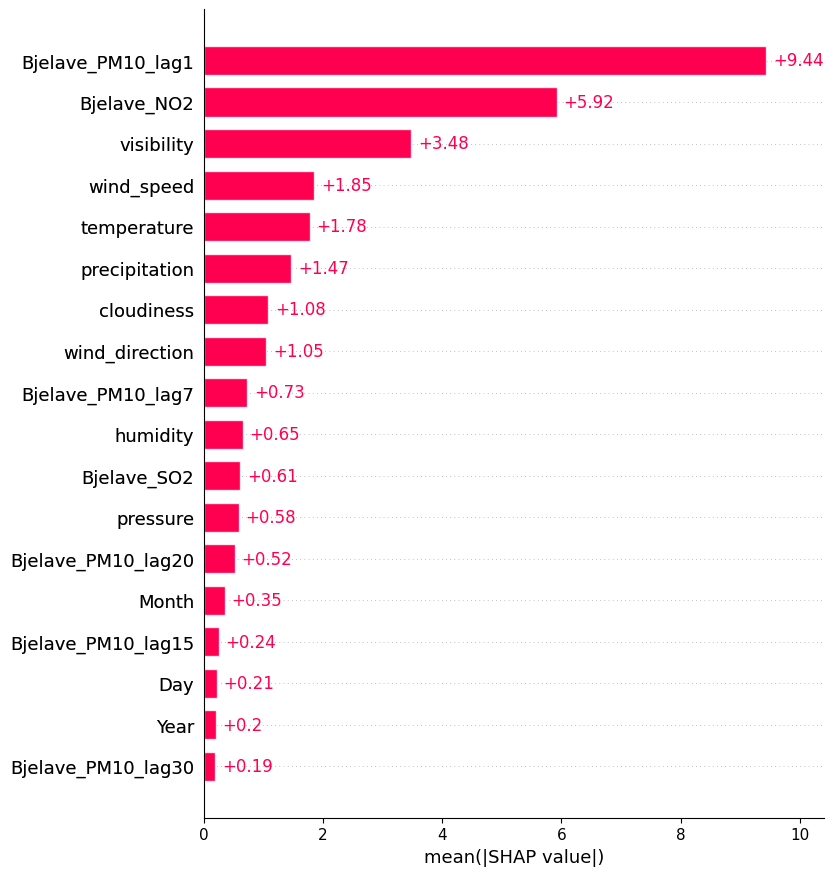

In [339]:
X_sample_ninety = test_data_combined_ws_ninety_dt[features]
shap_values_ninety = explainer_ninety.shap_values(X_sample_ninety)

shap.summary_plot(shap_values_ninety, X_sample_ninety)
explainer_ninety_mod = shap.Explanation(
    values=shap_values_ninety,
    base_values=np.array([explainer_ninety.expected_value] * len(shap_values_ninety)),
    data=X_sample_ninety.values,
    feature_names=features
)

shap.plots.bar(explainer_ninety_mod, max_display=len(features))

In [340]:
lag_features = ['lag30', 'lag20', 'lag15', 'lag7', 'lag1']
temporal_features = ['Day', 'Month', 'Year']

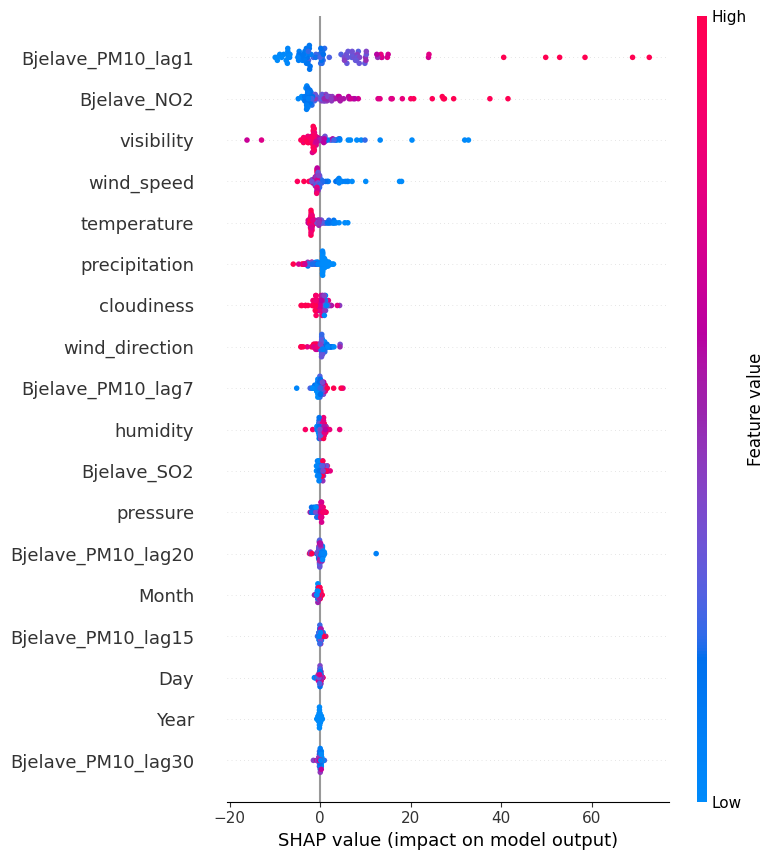

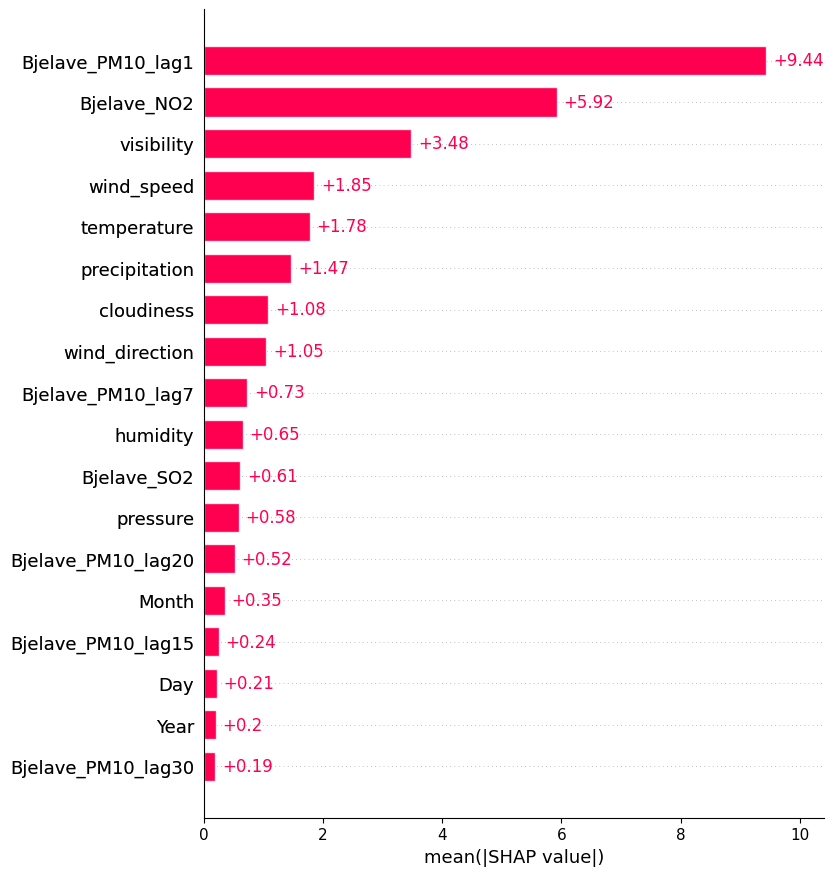

In [341]:
X_sample_ninety = test_data_combined_ws_ninety_dt[features]
shap_values_ninety = explainer_ninety.shap_values(X_sample_ninety)

shap.summary_plot(shap_values_ninety, X_sample_ninety)
explainer_ninety_mod = shap.Explanation(
    values=shap_values_ninety,
    base_values=np.array([explainer_ninety.expected_value] * len(shap_values_ninety)),
    data=X_sample_ninety.values,
    feature_names=features
)

shap.plots.bar(explainer_ninety_mod, max_display=len(features))

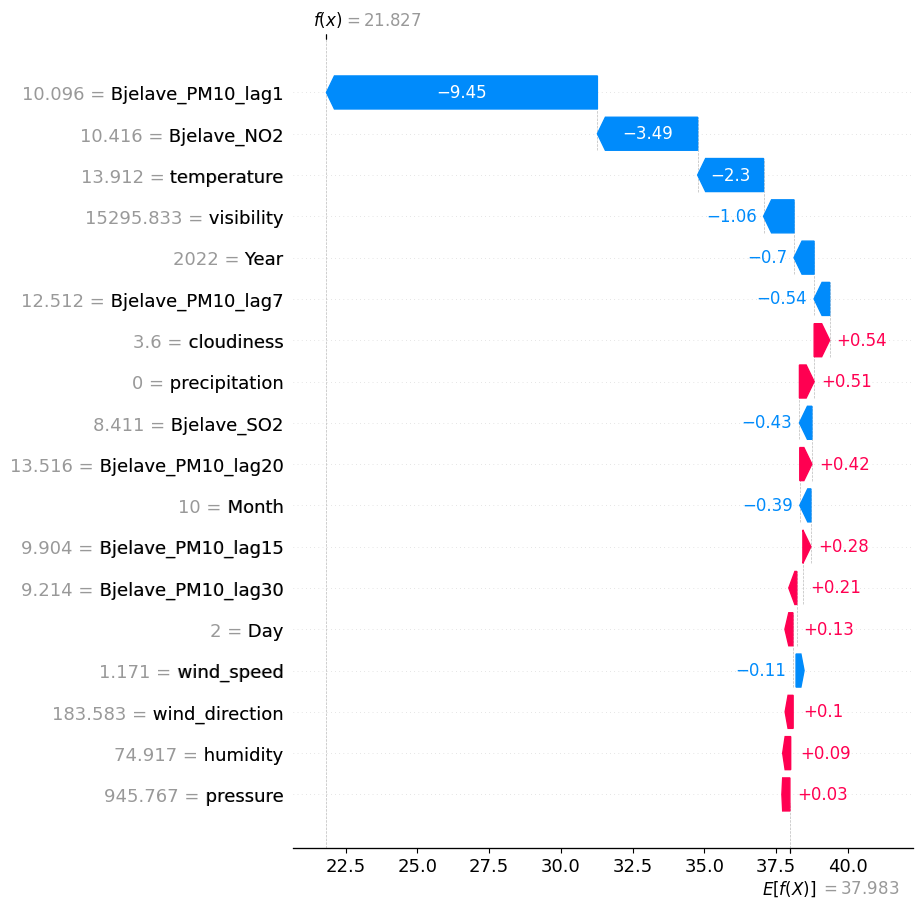

In [345]:
shap.plots.waterfall(explainer_ninety_mod[0], max_display=len(features))

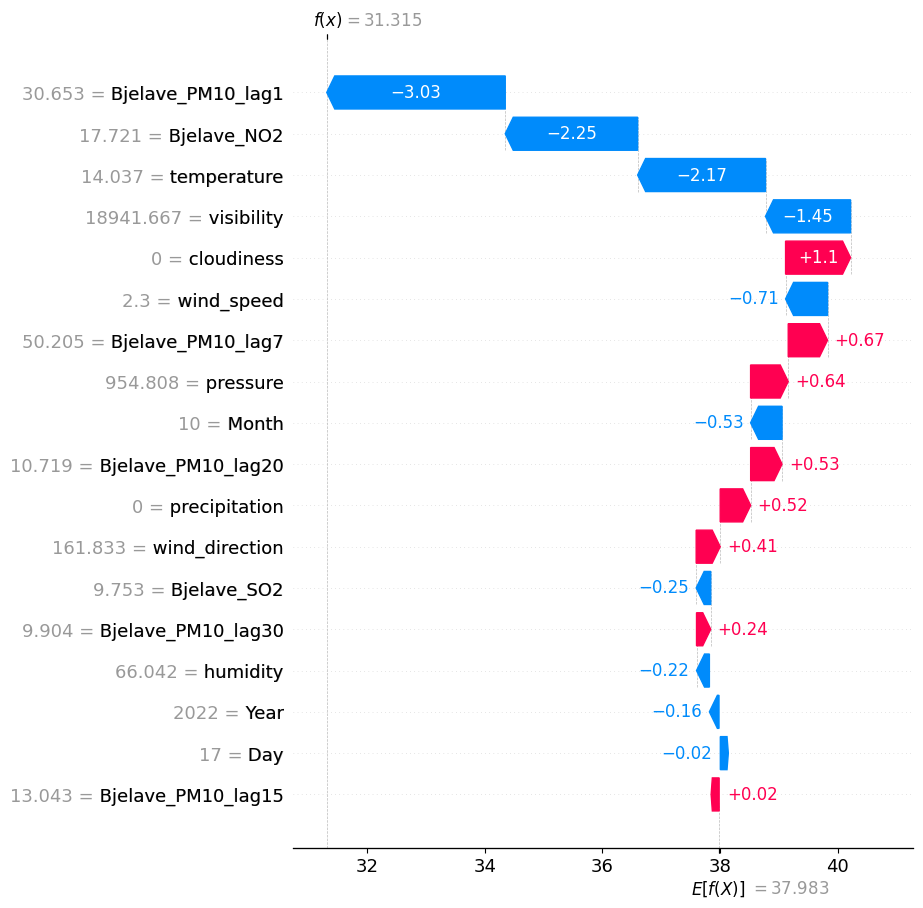

In [348]:
shap.plots.waterfall(explainer_ninety_mod[15], max_display=len(features))

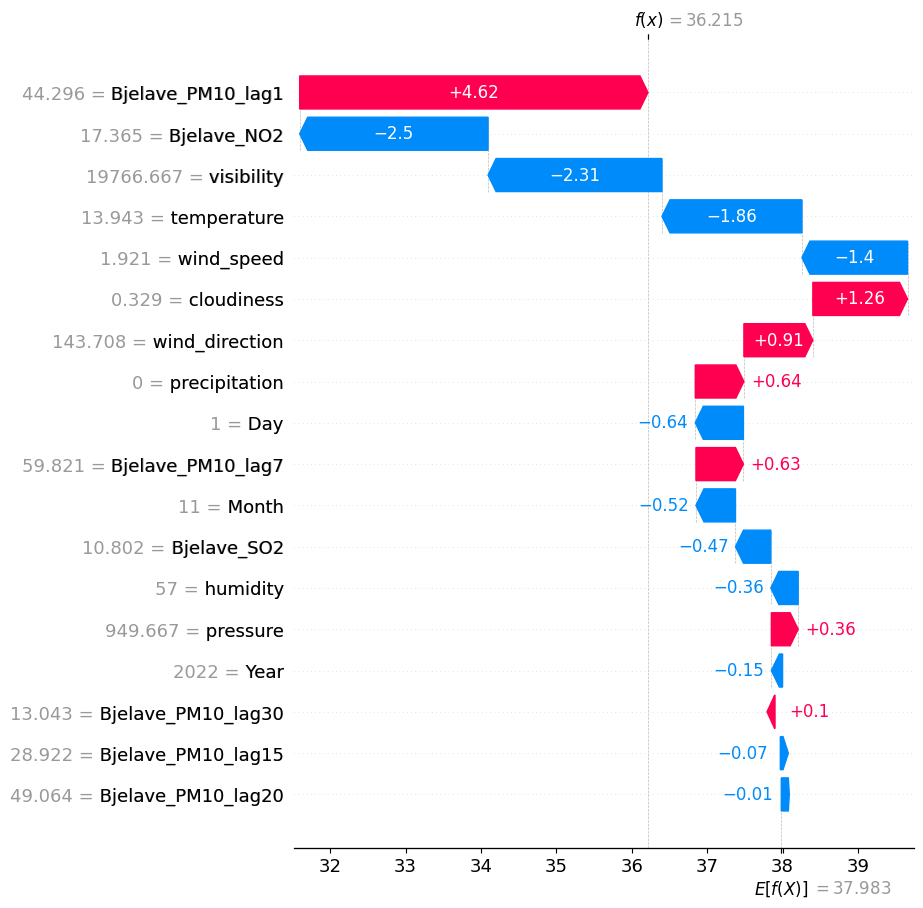

In [349]:
shap.plots.waterfall(explainer_ninety_mod[30], max_display=len(features))